### Урок 9. Использование на практике методов снижения размерности
Использование алгоритмов понижения размерности для улучшения классификации новостей (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)

Цель задания: Исследовать влияние различных методов понижения размерности на качество классификации текстовых данных.

Датасет: Набор данных новостных статей
(датасет '20 Newsgroups' доступный в sklearn.datasets).

Задачи:

1. Загрузите датасет '20 Newsgroups' из sklearn.

2. Проведите предобработку данных (очистка текста, удаление стоп-слов, векторизация с использованием TF-IDF).

3. Примените к полученным векторам TF-IDF следующие методы понижения размерности:
— PCA (Principal Component Analysis)
— t-SNE (t-distributed Stochastic Neighbor Embedding)
— UMAP (Uniform Manifold Approximation and Projection).

4. После понижения размерности данных используйте любой метод машинного обучения для классификации новостей по темам.

5. Сравните качество классификации для каждого метода понижения размерности. Используйте метрики точности и F1-меру.

6. Визуализируйте двумерное представление данных для каждого метода понижения размерности, чтобы оценить, как алгоритмы справляются с сепарацией классов.

7. Напишите отчёт, в котором обсудите, какой метод понижения размерности оказал наиболее значительное влияние на качество классификации и почему.

In [50]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import pandas as pd

#### 1. Загрузите датасет '20 Newsgroups' из sklearn.

In [51]:
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [52]:
newsgroups_df = pd.DataFrame(newsgroups.data)

In [53]:
newsgroups.target

array([7, 4, 4, ..., 3, 1, 8])

In [54]:
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [55]:
#соберем в датафрейм новости и таргет, посмотрим пропуски и дубликаты
newsgroups_df['target']= pd.DataFrame(newsgroups.target)
newsgroups_df=newsgroups_df.rename(columns={0:'news'})
newsgroups_df.head()

,news,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [56]:
newsgroups_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    11314 non-null  object
 1   target  11314 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 132.7+ KB


In [57]:
newsgroups_df.target.value_counts()

target
10    600
15    599
8     598
9     597
11    595
7     594
13    594
5     593
14    593
2     591
12    591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: count, dtype: int64

#### 2. Проведите предобработку данных (очистка текста, удаление стоп-слов, векторизация с использованием TF-IDF).

Видим, что пустых данных в датасете нет, но новости содержат знаки пунктуации, заглавные буквы, почистим данные.

In [58]:
# Предобработка данных
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess(text):
    # Токенизация по словам и приведение к нижнему регистру
    words = nltk.word_tokenize(text.lower())
    # Удаление стоп-слов и пунктуации
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_words)

newsgroups_df['cleaned_news'] = newsgroups_df['news'].apply(preprocess)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olesya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Olesya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Olesya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [59]:
newsgroups_df.drop('news', inplace=True, axis=1)
newsgroups_df.head()

,target,cleaned_news
0,7,wondering anyone could enlighten car saw day s...
1,4,fair number brave soul upgraded si clock oscil...
2,4,well folk mac plus finally gave ghost weekend ...
3,1,weitek number like get information chip
4,14,article tombaker tom baker understanding error...


In [60]:
newsgroups_df.duplicated().sum()

345

In [61]:
#наши данные содержат 345 дубликатов, удалим их
newsgroups_df=newsgroups_df.drop_duplicates().reset_index ()

In [62]:
newsgroups_df.duplicated().sum()

0

In [63]:
del newsgroups_df['index']

In [64]:
newsgroups_df

,target,cleaned_news
0,7,wondering anyone could enlighten car saw day s...
1,4,fair number brave soul upgraded si clock oscil...
2,4,well folk mac plus finally gave ghost weekend ...
3,1,weitek number like get information chip
4,14,article tombaker tom baker understanding error...
...,...,...
10964,13,dn nyeda david nye dn neurology dn consultatio...
10965,4,old mac mac plus problem screen blank sometime...
10966,3,installed cpu clone motherboard tried mounting...
10967,1,would require point specifies sphere far see u...


In [69]:
# Векторизация текста с помощью TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(newsgroups_df['cleaned_news'])
y= newsgroups_df['target']


#### 3. Примените к полученным векторам TF-IDF следующие методы понижения размерности:
— PCA (Principal Component Analysis)

— t-SNE (t-distributed Stochastic Neighbor Embedding) 

— UMAP (Uniform Manifold Approximation and Projection). 

In [71]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train.toarray())
X_test_pca = pca.transform(X_test.toarray())

In [73]:
# Получение компонент
components = pca.components_

# Создание DataFrame с компонентами PCA
components_df = pd.DataFrame(components, columns=vectorizer.get_feature_names_out())

# Вывод вклада каждой переменной для первой и второй главных компонент
components_df

,aa,aaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,aaah,aaahh,aaahhhh,aaai,aacc,aacvkc,...,zz,zzcrm,zzneu,zznki,zznkzz,zznp,zzz,zzzoh,zzzzzz,zzzzzzt
0,-0.000576,-0.001610,-0.000179,-0.000171,-0.000385,0.000146,0.000527,1.704724e-19,-0.000088,0.000069,...,0.000067,0.000035,0.000007,0.000007,0.000006,0.000013,-0.000286,0.000011,-0.000075,-0.000275
1,-0.001299,-0.005899,0.000179,-0.000387,0.000043,0.000168,0.000125,5.050610e-18,0.000026,-0.000041,...,-0.001323,-0.000135,-0.000039,-0.000039,-0.000045,-0.000058,-0.000624,-0.000032,-0.000634,-0.000265


In [74]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train.toarray())
X_test_tsne = tsne.fit_transform(X_test.toarray())

In [75]:
# Применение LLE
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2)
X_train_lle = lle.fit_transform(X_train.toarray())
X_test_lle = lle.transform(X_test.toarray())

#### 4. После понижения размерности данных используйте любой метод машинного обучения для классификации новостей по темам.

In [76]:
from sklearn.ensemble import RandomForestClassifier

# Обучим модель логистической регрессия
model = RandomForestClassifier(random_state=42)

In [77]:
# PCA 
model.fit(X_train_pca, y_train)
y_pred_pca = model.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca, average='macro')
print(f"PCA Accuracy: {accuracy_pca:.3f}, F1 Score: {f1_pca:.3f}")

PCA Accuracy: 0.178, F1 Score: 0.173


In [78]:
#t-SNE
model.fit(X_train_tsne, y_train)
y_pred_tsne = model.predict(X_test_tsne)
accuracy_tsne = accuracy_score(y_test, y_pred_tsne)
f1_tsne = f1_score(y_test, y_pred_tsne, average='macro')
print(f"t-SNE Accuracy: {accuracy_tsne:.3f}, F1 Score: {f1_tsne:.3f}")

t-SNE Accuracy: 0.088, F1 Score: 0.085


In [79]:
# LLE
model.fit(X_train_lle, y_train)
y_pred_lle = model.predict(X_test_lle)
accuracy_tsne = accuracy_score(y_test, y_pred_lle)
f1_tsne = f1_score(y_test, y_pred_lle, average='macro')
print(f"LLE Accuracy: {accuracy_tsne:.3f}, F1 Score: {f1_tsne:.3f}")

LLE Accuracy: 0.050, F1 Score: 0.007


Визуализация данных

Вклад переменных в первую компоненту: [-5.76336073e-04 -1.61013435e-03 -1.78791847e-04 ...  1.14663503e-05
 -7.52487167e-05 -2.75359809e-04]
Вклад переменных во вторую компоненту: [-1.29893668e-03 -5.89862414e-03  1.78972931e-04 ... -3.24387446e-05
 -6.33615925e-04 -2.65431738e-04]


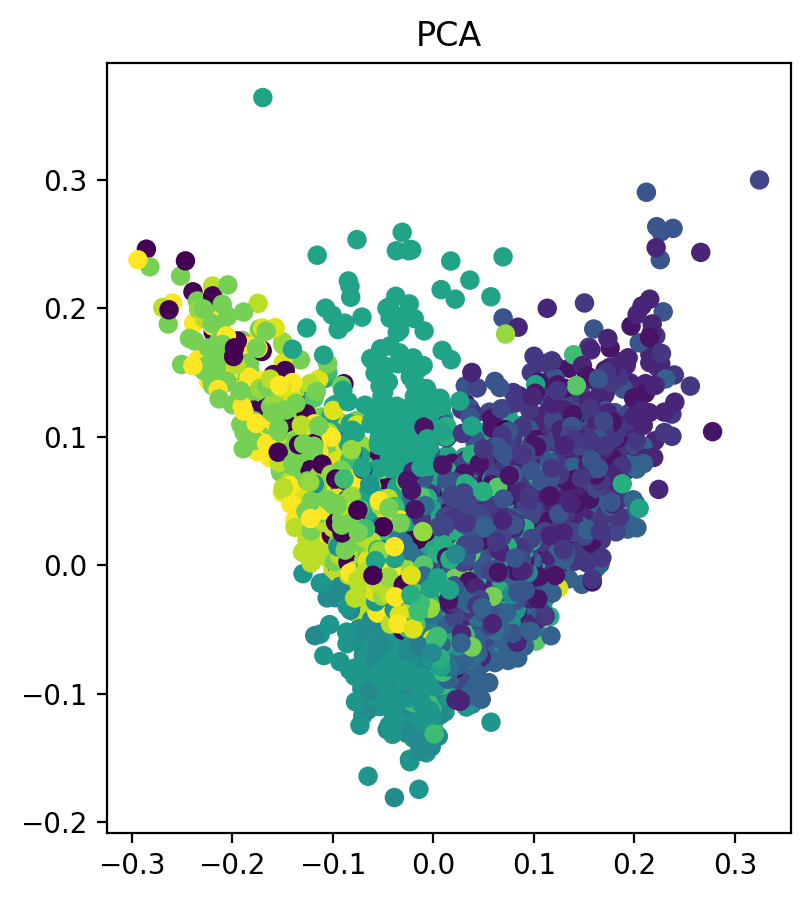

In [80]:
plt.figure(figsize=(15, 5), dpi=200)

plt.subplot(1, 3, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.title("PCA")

# вывод влияния признаков на компоненты
print("Вклад переменных в первую компоненту:", pca.components_[0])
print("Вклад переменных во вторую компоненту:", pca.components_[1])

Text(0.5, 1.0, 't-SNE')

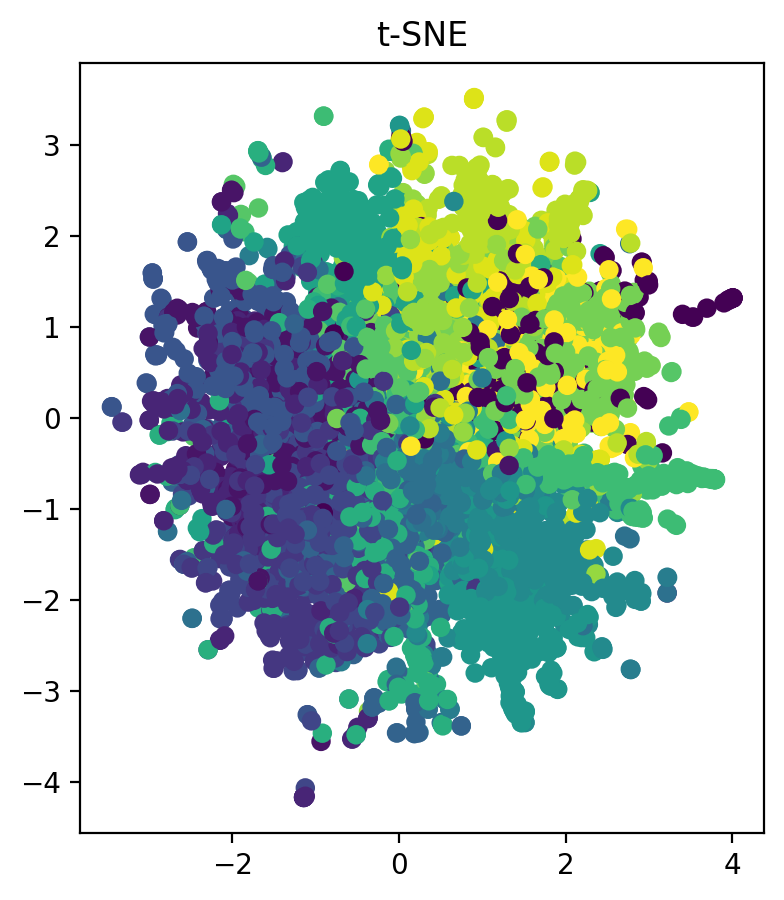

In [81]:
plt.figure(figsize=(15, 5), dpi=200)
plt.subplot(1, 3, 2)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train)
plt.title("t-SNE")

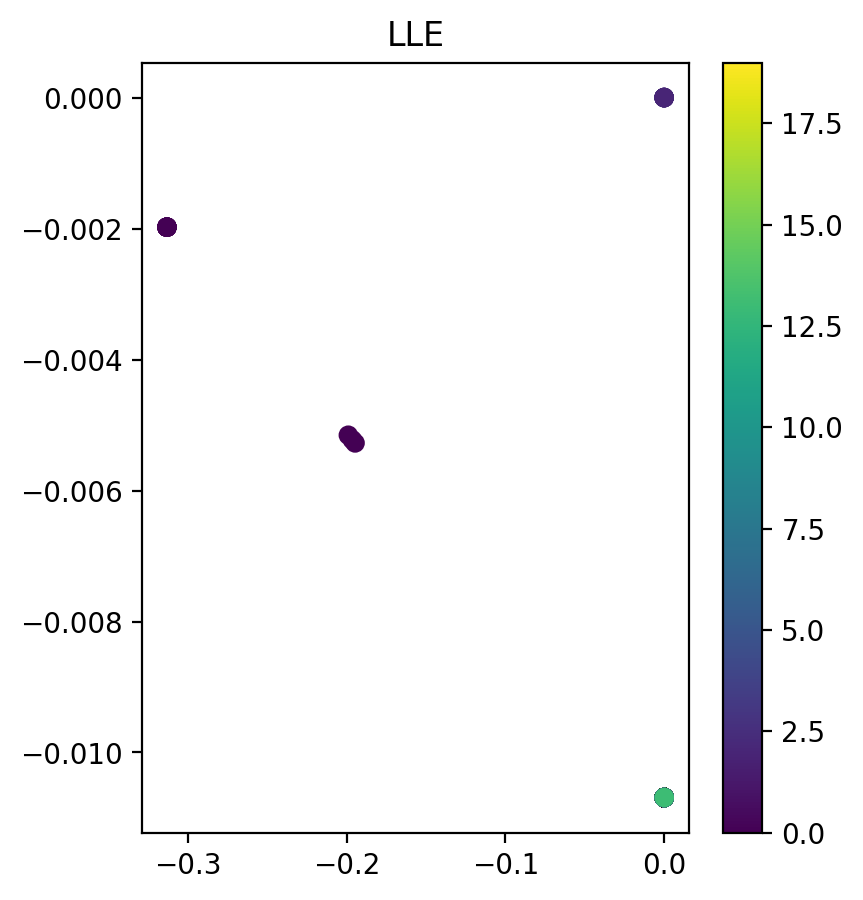

In [82]:
plt.figure(figsize=(15, 5), dpi=200)
plt.subplot(1, 3, 2)
plt.scatter(X_train_lle[:, 0], X_train_lle[:, 1], c=y_train)
plt.title("LLE")
plt.colorbar()